In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 44ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 41ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 39ms/step - loss: 192.3058 - mae: 192.8058
Epoch 5/100
8/8 [==============================] - 0s 38ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 42ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 40ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/100
8/8 [==============================] - 0s 41ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/100
8/8 [==============================] - 0s 41ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/100
8/8 [===========

Epoch 87/100
8/8 [==============================] - 0s 38ms/step - loss: 19.8221 - mae: 20.3142
Epoch 88/100
8/8 [==============================] - 0s 42ms/step - loss: 28.7486 - mae: 29.2461
Epoch 89/100
8/8 [==============================] - 0s 44ms/step - loss: 18.8222 - mae: 19.3145
Epoch 90/100
8/8 [==============================] - 0s 40ms/step - loss: 19.0956 - mae: 19.5918
Epoch 91/100
8/8 [==============================] - 0s 41ms/step - loss: 41.3958 - mae: 41.8947
Epoch 92/100
8/8 [==============================] - 0s 39ms/step - loss: 25.5490 - mae: 26.0458
Epoch 93/100
8/8 [==============================] - 0s 38ms/step - loss: 25.6494 - mae: 26.1471
Epoch 94/100
8/8 [==============================] - 0s 37ms/step - loss: 17.5771 - mae: 18.0710
Epoch 95/100
8/8 [==============================] - 0s 40ms/step - loss: 21.4463 - mae: 21.9404
Epoch 96/100
8/8 [==============================] - 0s 38ms/step - loss: 37.1719 - mae: 37.6706
Epoch 97/100
8/8 [======================

(1e-08, 0.0001, 0.0, 30.0)

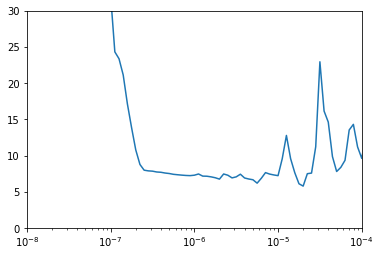

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 40ms/step - loss: 114.4028 - mae: 114.9028
Epoch 2/400
8/8 [==============================] - 0s 41ms/step - loss: 22.2723 - mae: 22.7647
Epoch 3/400
8/8 [==============================] - 0s 38ms/step - loss: 17.3886 - mae: 17.8839
Epoch 4/400
8/8 [==============================] - 0s 37ms/step - loss: 13.2057 - mae: 13.7010
Epoch 5/400
8/8 [==============================] - 0s 41ms/step - loss: 9.7391 - mae: 10.2285
Epoch 6/400
8/8 [==============================] - 0s 37ms/step - loss: 15.1328 - mae: 15.6271
Epoch 7/400
8/8 [==============================] - 0s 41ms/step - loss: 14.4423 - mae: 14.9355
Epoch 8/400
8/8 [==============================] - 0s 40ms/step - loss: 10.9539 - mae: 11.4453
Epoch 9/400
8/8 [==============================] - 0s 42ms/step - loss: 9.7167 - mae: 10.2063
Epoch 10/400
8/8 [==============================] - 0s 42ms/step - loss: 11.5552 - mae: 12.0489
Epoch 11/400
8/8 [==============================]

8/8 [==============================] - 0s 40ms/step - loss: 10.2507 - mae: 10.7428
Epoch 88/400
8/8 [==============================] - 0s 41ms/step - loss: 8.8608 - mae: 9.3484
Epoch 89/400
8/8 [==============================] - 0s 40ms/step - loss: 6.4744 - mae: 6.9602
Epoch 90/400
8/8 [==============================] - 0s 39ms/step - loss: 5.3653 - mae: 5.8457
Epoch 91/400
8/8 [==============================] - 0s 40ms/step - loss: 4.7053 - mae: 5.1880
Epoch 92/400
8/8 [==============================] - 0s 40ms/step - loss: 4.6543 - mae: 5.1303
Epoch 93/400
8/8 [==============================] - 0s 40ms/step - loss: 5.0650 - mae: 5.5429
Epoch 94/400
8/8 [==============================] - 0s 40ms/step - loss: 5.7057 - mae: 6.1909
Epoch 95/400
8/8 [==============================] - 0s 41ms/step - loss: 5.0800 - mae: 5.5595
Epoch 96/400
8/8 [==============================] - 0s 38ms/step - loss: 5.1101 - mae: 5.5876
Epoch 97/400
8/8 [==============================] - 0s 38ms/step - loss

8/8 [==============================] - 0s 40ms/step - loss: 6.1086 - mae: 6.5895
Epoch 174/400
8/8 [==============================] - 0s 41ms/step - loss: 5.4558 - mae: 5.9344
Epoch 175/400
8/8 [==============================] - 0s 40ms/step - loss: 6.6330 - mae: 7.1197
Epoch 176/400
8/8 [==============================] - 0s 39ms/step - loss: 6.6514 - mae: 7.1380
Epoch 177/400
8/8 [==============================] - 0s 37ms/step - loss: 5.8930 - mae: 6.3796
Epoch 178/400
8/8 [==============================] - 0s 42ms/step - loss: 4.7439 - mae: 5.2250
Epoch 179/400
8/8 [==============================] - 0s 39ms/step - loss: 4.8390 - mae: 5.3167
Epoch 180/400
8/8 [==============================] - 0s 40ms/step - loss: 6.9688 - mae: 7.4548
Epoch 181/400
8/8 [==============================] - 0s 42ms/step - loss: 7.9079 - mae: 8.3944
Epoch 182/400
8/8 [==============================] - 0s 41ms/step - loss: 7.6280 - mae: 8.1158
Epoch 183/400
8/8 [==============================] - 0s 41ms/ste

Epoch 259/400
8/8 [==============================] - 0s 44ms/step - loss: 5.7701 - mae: 6.2521
Epoch 260/400
8/8 [==============================] - 0s 40ms/step - loss: 6.3639 - mae: 6.8474
Epoch 261/400
8/8 [==============================] - 0s 38ms/step - loss: 7.3754 - mae: 7.8633
Epoch 262/400
8/8 [==============================] - 0s 39ms/step - loss: 4.6285 - mae: 5.1078
Epoch 263/400
8/8 [==============================] - 0s 38ms/step - loss: 4.5959 - mae: 5.0724
Epoch 264/400
8/8 [==============================] - 0s 40ms/step - loss: 4.6878 - mae: 5.1654
Epoch 265/400
8/8 [==============================] - 0s 41ms/step - loss: 5.4028 - mae: 5.8842
Epoch 266/400
8/8 [==============================] - 0s 42ms/step - loss: 4.4954 - mae: 4.9752
Epoch 267/400
8/8 [==============================] - 0s 42ms/step - loss: 4.2595 - mae: 4.7338
Epoch 268/400
8/8 [==============================] - 0s 42ms/step - loss: 4.2200 - mae: 4.6866
Epoch 269/400
8/8 [==============================]

8/8 [==============================] - 0s 40ms/step - loss: 6.7764 - mae: 7.2650
Epoch 345/400
8/8 [==============================] - 0s 43ms/step - loss: 4.3423 - mae: 4.8208
Epoch 346/400
8/8 [==============================] - 0s 39ms/step - loss: 4.2979 - mae: 4.7690
Epoch 347/400
8/8 [==============================] - 0s 38ms/step - loss: 4.8522 - mae: 5.3347
Epoch 348/400
8/8 [==============================] - 0s 40ms/step - loss: 5.8146 - mae: 6.2934
Epoch 349/400
8/8 [==============================] - 0s 38ms/step - loss: 5.2332 - mae: 5.7149
Epoch 350/400
8/8 [==============================] - 0s 38ms/step - loss: 4.8060 - mae: 5.2888
Epoch 351/400
8/8 [==============================] - 0s 40ms/step - loss: 5.6911 - mae: 6.1748
Epoch 352/400
8/8 [==============================] - 0s 40ms/step - loss: 6.4627 - mae: 6.9484
Epoch 353/400
8/8 [==============================] - 0s 41ms/step - loss: 5.3137 - mae: 5.7937
Epoch 354/400
8/8 [==============================] - 0s 40ms/ste

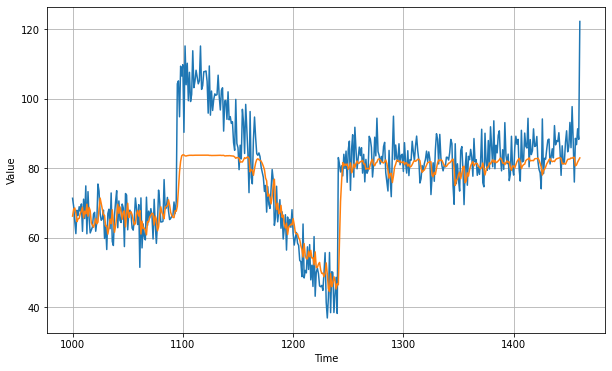

In [8]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.5029936

<Figure size 432x288 with 0 Axes>

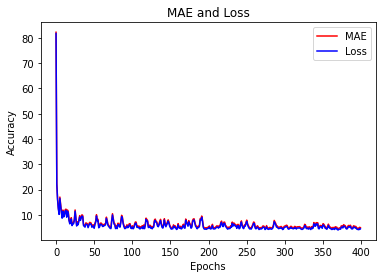

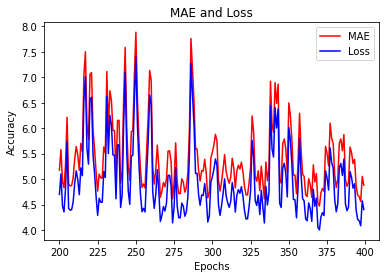

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()